# Homework 1


### TODO:
 * ~~part H - plot ROC curves~~
     * answer Questions

### Cancer Diagnosis Using Machine Learning

*imports*

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import resample
from sklearn.ensemble import AdaBoostClassifier
#from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

%matplotlib inline

---

### __a. Read the dataset file “Cancer.csv” (you should download it from CSNS), and store it in a Pandas DataFrame.__

* Check out the dataset.

* The dataset includes 9 numerical features.

* The last column is the binary label (“1” means it is a malignant cancer, “0” means it is a benign tumor).

* You will use all 9 features in this homework.

In [2]:
data = pd.read_csv("HW1/Cancer.csv")


In [3]:
feature_names = [
    "Clump_Thickness",
    "Uniformity_of_Cell_Size",
    "Uniformity_of_Cell_Shape",
    "Marginal_Adhesion",
    "Single_Epithelial_Cell_Size",
    "Bare_Nuclei",
    "Bland_Chromatin",
    "Normal_Nucleoli",
    "Mitoses"
]

X = data[feature_names]

y = data["Malignant_Cancer"]


*display features*

In [4]:
X.head()


,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


*display labels*

In [5]:
y.head()


0    0
1    0
2    0
3    0
4    0
Name: Malignant_Cancer, dtype: int64

---

### __b. Use sklearn functions to split the dataset into testing and training sets with the following parameters:__

```test_size=0.3, random_state=2```

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)


---

### __c. Use “Decision Tree Classifier” to predict Cancer based on the training/testing datasets that you built in part (b).__

* Then, calculate and report the accuracy and AUC of your classifier.

* Later in __part (g)__, you will plot the `ROC curve` as well. Use this command to define your tree:

  ```my_DecisionTree = DecisionTreeClassifier(random_state=2)```

In [7]:
my_DecisionTree = DecisionTreeClassifier(random_state = 2)
my_DecisionTree.fit(X_train, y_train)
dt_prediction = my_DecisionTree.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_prediction)


*show decision tree accuracy*

In [8]:
print("Decision Tree Accuracy:", dt_accuracy)


Decision Tree Accuracy: 0.8666666666666667


In [9]:
dt_false_pr, dt_true_pr, dt_thresholds = metrics.roc_curve(y_test, dt_prediction, pos_label = 1)

dt_AUC = metrics.auc(dt_false_pr, dt_true_pr)

print("Decision Tree AUC:", dt_AUC)


Decision Tree AUC: 0.8697478991596639


---

### __d. Now, we want to perform “Bagging” based on 29 “base decision tree classifiers”.__

---

  __NOTE:__

    You should write your own code to perform Bagging (don’t use scikit-learn functions for Bagging!)
    
---
    
  To do so, you need to perform bootstrapping first. You can write a “for” loop with loop variable `i = 0...18`.
  
  __In each iteration of the loop, you have to:__
  
  
  - Make a bootstrap sample of the original “Training” Dataset (built in __part (b)__ ) with size of:
  
      `bootstrap_size = 0.8*(Size of the original dataset)`.
  
  You can use the following command to generate a random bootstrap dataset (“i" is the variable of the loop, so the random_state changes in each iteration):
  
  ```resample(X_train, n_samples = bootstrap_size , random_state=i , replace = True)```
  
  
  - Define and train a new base decision tree classifier on this dataset in each iteration:
    
    ```Base_DecisionTree = DecisionTreeClassifier(random_state=2)```
  
  
  - Test “this base classifier” on the original “Testing” Dataset build in __part (b)__, and save the prediction results for all testing samples.
  
Then, Perform Voting to make the final decision on each data sample based on the votes of all 29 classifiers.

Finally, calculate and report the accuracy and AUC of your Bagging method.

---

  __NOTE:__
  
    You need to calculate the probability of “malignant cancer” to be able to find AUC and plot the ROC curve. As mentioned in the class, you can consider the average (mean) of the votes as the probability for each sample.
    
---

In [10]:
base_decision_tree_classifiers = 29

size_of_original_dataset = X_train.shape[0]

bootstrap_size = int(0.8 * size_of_original_dataset)
print("Booststrap size:", bootstrap_size)


Booststrap size: 84


*bootstrapping*

In [11]:
prediction_list = pd.DataFrame()

for i in range(base_decision_tree_classifiers):
    X_train_i = resample(X_train, n_samples = bootstrap_size, random_state = i, replace = True)
    y_train_i = resample(y_train, n_samples = bootstrap_size, random_state = i, replace = True)
    
    Base_DecisionTree = DecisionTreeClassifier(random_state = 2)
    Base_DecisionTree.fit(X_train_i, y_train_i)
    
    y_predict_bdt = Base_DecisionTree.predict(X_test)
    
    prediction_list[i] = y_predict_bdt


*voting*

In [38]:
voting = prediction_list.mode(axis = 1)
#print("Number of Votes:", voting.size)

*accuracy*

In [39]:
bag_accuracy = accuracy_score(y_test, voting)
print("Bagging Accuracy:", bag_accuracy)


Bagging Accuracy: 0.9111111111111111


In [40]:
bag_false_pr, bag_true_pr, bag_thresholds = metrics.roc_curve(y_test, voting, pos_label = 1)

bag_AUC = metrics.auc(bag_false_pr, bag_true_pr)

print("Bagging AUC:", bag_AUC)


Bagging AUC: 0.9054621848739496


---

### __e. Use scikit-learn “Adaboost” classifier to predict Cancer based on the training/testing datasets that you built in part (b).__

* Then, calculate and report the accuracy and AUC of your classifier. Use this command to import and define your classifier:

    ```from sklearn.ensemble import AdaBoostClassifier```
    
    ``` my_AdaBoost = AdaBoostClassifier(n_estimators = 29,random_state=2)```

In [15]:
my_AdaBoost = AdaBoostClassifier(n_estimators = 29, random_state = 2)


In [16]:
my_AdaBoost.fit(X_train, y_train)
ada_prediction = my_AdaBoost.predict(X_test)
ada_accuracy = accuracy_score(y_test, ada_prediction)


In [17]:
print("AdaBoost Accuracy:", ada_accuracy)


AdaBoost Accuracy: 0.9555555555555556


In [18]:
ada_false_pr, ada_true_pr, ada_thresholds = metrics.roc_curve(y_test, ada_prediction, pos_label = 1)

ada_AUC = metrics.auc(ada_false_pr, ada_true_pr)

print("AdaBoost AUC:", ada_AUC)


AdaBoost AUC: 0.9527310924369748


---

### __f. In this section, we use an extremely popular Boosting algorithm called “XGBoost”.__
  This algorithm is not included in sklearn, so you need to install the XGBoost library.
  
  Please see this for more info: https://xgboost.readthedocs.io/en/latest/build.html
  
  Mac users can easily install it with “`pip install xgboost`”.

* Repeat __part (e)__ with XGBoost.

  - Use this command to import and define your classifier:
  
    ```from xgboost import XGBClassifier```
  
    ```my_XGBoost = XGBClassifier(n_estimators = 29,random_state=2)```

In [19]:
my_XGBoost = xgb.XGBClassifier(n_estimators = 29, n_jobs = -1, random_state = 2)


In [20]:
#dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = feature_names, nthread=-1) # no need to convert
#my_XGBoost.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

my_XGBoost.fit(X_train, y_train)

xgb_prediction = my_XGBoost.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_prediction)


In [21]:
print("XGBoost Accuracy:", xgb_accuracy)


XGBoost Accuracy: 0.9555555555555556


In [22]:
xgb_false_pr, xgb_true_pr, xgb_thresholds = metrics.roc_curve(y_test, xgb_prediction, pos_label = 1)

xgb_AUC = metrics.auc(xgb_false_pr, xgb_true_pr)

print("XGBoost AUC:", xgb_AUC)


XGBoost AUC: 0.9527310924369748


---

### __g. Use scikit-learn “Random Forest” classifier to predict Cancer based on the training/testing datasets that you built in part (b).__

* Then, calculate and report the accuracy and AUC of your classifier.
  - Use this command to import and define your classifier:
  
    ```from sklearn.ensemble import RandomForestClassifier```
  
    ```my_RandomForest = RandomForestClassifier(n_estimators = 29, bootstrap = True, random_state=2)```

In [23]:
my_RandomForest = RandomForestClassifier(n_estimators = 29, bootstrap = True, random_state = 2)


In [24]:
my_RandomForest.fit(X_train, y_train)
rf_prediction = my_RandomForest.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_prediction)


In [25]:
print("Random Forest Accuracy:", rf_accuracy)


Random Forest Accuracy: 0.9555555555555556


In [26]:
rf_false_pr, rf_true_pr, rf_thresholds = metrics.roc_curve(y_test, rf_prediction, pos_label = 1)

rf_AUC = metrics.auc(rf_false_pr, rf_true_pr)

print("Random Forest AUC:", rf_AUC)


Random Forest AUC: 0.9411764705882353


---

## __h. Now, plot the ROC curves of your algorithms in parts (c), (d), (e), (f), (g) in a single plane with different colors along with the name of each method.__

    Show the AUCs on the graph as well.
    
    - Which algorithm is the best w.r.t the AUC value?
    
    - Which algorithm is the best w.r.t the Accuracy value?
    
    - Which algorithm is the best when we want a False Positive Rate of 7%?

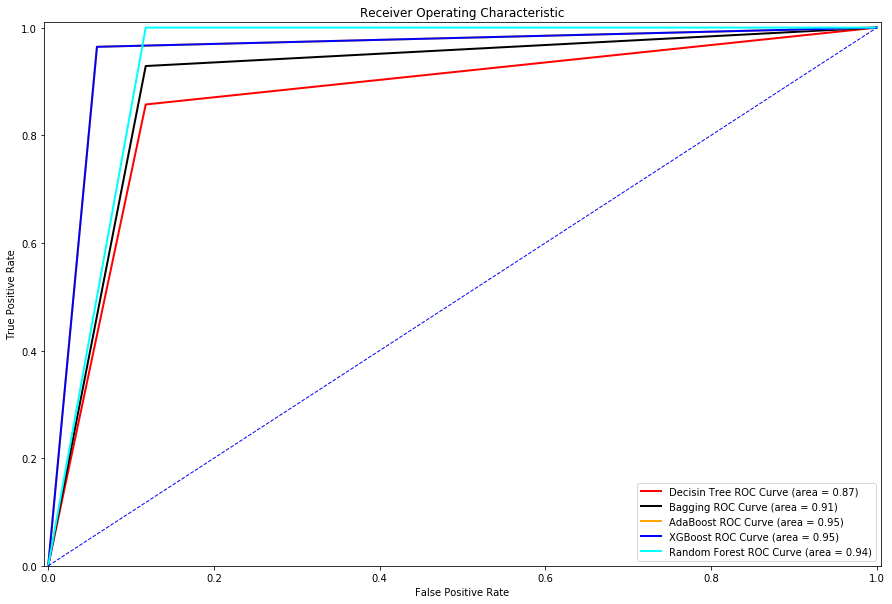

In [53]:
plt.figure(figsize=(15, 10) )

plt.plot(dt_false_pr, dt_true_pr, color="red", lw = 2, label = "Decisin Tree ROC Curve (area = %0.2f)" % dt_AUC)
plt.plot(bag_false_pr, bag_true_pr, color="black", lw = 2, label = "Bagging ROC Curve (area = %0.2f)" % bag_AUC)
plt.plot(ada_false_pr, ada_true_pr, color="orange", lw = 2, label = "AdaBoost ROC Curve (area = %0.2f)" % ada_AUC)
plt.plot(xgb_false_pr, xgb_true_pr, color="blue", lw = 2, label = "XGBoost ROC Curve (area = %0.2f)" % xgb_AUC)
plt.plot(rf_false_pr, rf_true_pr, color="cyan", lw = 2, label = "Random Forest ROC Curve (area = %0.2f)" % rf_AUC)

plt.plot([0, 1], [0, 1], color="blue", lw = 1, linestyle = "--")

plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

plt.show()

---